### Multivariate state estimation technique

Моделирование системы в **$MSET$ использует данные, представляющие нормальные рабочие состояния системы** (данные без аномалий), и изучает взаимосвязи, существующие между переменными, используемыми для определения состояния. Иными словами, есть набор переменных которые описывают нормальное рабочее состояние системы. С помощью метода изучаются связи между такими переменными. Тогда при анализе данных с аномалиями эти связи могут быть нарушены, что и служит индикатором для обнаружения аномалий.

Собранные данные организуются в виде матрицы, где каждый вектор-столбец представляет измерения в момент времени $t_j$. Количество столбцов этой матрицы равно количеству наблюдений во времени, а количество строк равно количеству измеряемых показателей. Например, можно измерять давление, температуру и напряжение - это строки в матрице, тогда каждый столбец это состояние в конкретный момент времени.

<img src="./img/mset_data.png" alt="Drawing" style="width: 400px; height: 200px"/>

В общем случае $x_{ji}$ - значение параметра $j$ в момент времени $i$. Тогда состояние в момент времени $X(t_i) = [x_{1i}, x_{2i} \ldots x_{ni}]^T$.

В процессе $MSET$ есть три ключевые процедуры (выполняются последовательно):
1. Выбор обучающих данных $T$ из матрицы $X_i(t_i)$.
2. Выбор данных для создания матрицы памяти $D$
3. Обучение и принятие решения

**Обучающие данные**. Определяются просто как $T \subset X_i(t_i)$, т.е. берется подмножество столбцов (состояний), при этом требуется чтобы данные не содержали аномалий и не нарушали целостность системы (это значит, что нельзя из момента времени выбросить один или несколько показателей). Размер подмножества $|T|$ определяется пользователем, скорее всего как гиперпараметр.

**Матрица памяти**. Определяется как подмножество $D \subset T$, при этом есть конструктивный алгоритм построения:
1. Состояния, которые содержат максимальные и минимальные значения характеристик системы, должны быть выбраны.
2. Из оставшихся данных выбираются состояния согласно алгоритму:
    * Упорядочиваем вектора на основе евклидовых норм
    * Добиваем до заданного вручную количества $|D|$ через равные интервалы
    * Оставшиеся состояния будут образовывать матрицу $L$

Таким образом $T = D \cup L$. Весь процесс можно представить в виде блок-схемы:

<img src="./img/mset_process.png" alt="Drawing" style="width: 700px; height: 200px"/>

Матрица $D$ характеризует нормальное рабочее состояние системы и играет ключевую роль. Именно под нее в процессе обучения выбираются веса по которым можно оценивать новые наблюдения.

**Обуение**. Итак, допустим мы построили матрицу памяти. Теперь нужно обучиться. Идея заключается просто во взвешивании, т.е. по сути решается задача регресии. Пусть $X_{obs}$ наблюдаемые новые состояния системы. Тогда $X_{est} = DW$, где $W$ - стобец весов. Ошибка обучения $\epsilon = X_{obs} - X_{est} = X_{obs} - DW$. Ясно, что $\epsilon \perp d_i$, где $d_i$ вектор-столбец из $D$. Почему это так? Рассмотрим задачу регресии как задачу проецирования из линейной алгберы.

Пусть у нас есть объекты $x \in R^n$, в качестве $n$ возьмем $3$, потому что это нагляднее, но на самом деле верно и для большего $n$. И пусть мы по двум измерениям (осям $X$ и $Y$) хотим предсказывать значение по оси $Z$. Окей, берем векторы в пространстве и просто проецируем на плоскость $XY$. В плоскости $XY$ есть базис, спроецированные векторы пространства можно единственным образом разложить по этому базису. Коэффициенты разложения по базису назовем весами. Тогда если вычесть из вектора в пространстве $XYZ$ его проекцию в $XY$, получим направляющий вектор плоскости $XY$. А значит любой вектор из плоскости, в том числе и базисный, перпендикулярен направляющему вектору. В этом примере базисные-вектора на плоскости это вектора матрицы $D$, направляющий вектор это $\epsilon$, а $X_{obs}$ это вектора в пространстве $XYZ$.

Поскольку $\epsilon \perp d_i$, то скалярное произведение $<\epsilon, d_i> = 0$, где $d_i$ вектор-столбец из матрицы $D$. Давайте рассмотрим скалярные произведение со всеми векторами из матрицы $D$, т.е. $<\epsilon, d_1> = <\epsilon, d_2> = \ldots = <\epsilon, d_{|D|}> = 0$. Это также можно записать в виде матричного умножения $D^T \epsilon = 0$. Подставим эпсилон и раскроем скобки, получается 
$$D^T(X_{obs} - DW) = 0$$
$$D^T X_{obs} = D^T D W$$
$$[D^TD]^{-1} [D^T X_{obs}] = W$$ при этом матрица $D^TD$ должна быть обратима

Иначе во второй строке обозначаем $D^TX_{obs} = B$, $D^TD = A$, $W = x$ и решаем СЛУ вида $Ax = B$

Таким образом находим вектор весов, тогда $X_{est} = D [D^TD]^{-1} [ D^T X_{obs}]$

Аналогично оцениваем остатки матрицы $L$, а затем легко вычисляем остатки $R_X = X_{est} - X_{obs}$ и $R_L = L_{est} - L_{obs}$

**Принятие решения**. Наша цель обнаружить аномалии, поэтому нужно оценить остатки на соответствие белому шуму. Это можно сделать, например, с помощью метода статистического принятия решений $SPRT$ [cool theory with example](https://www.weibull.com/hotwire/issue162/hottopics162.htm)

### Обнаружение аномалий step-by-step

In [5]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import warnings 
warnings.filterwarnings('ignore')

from utils.metrics import far, mar, f1_score

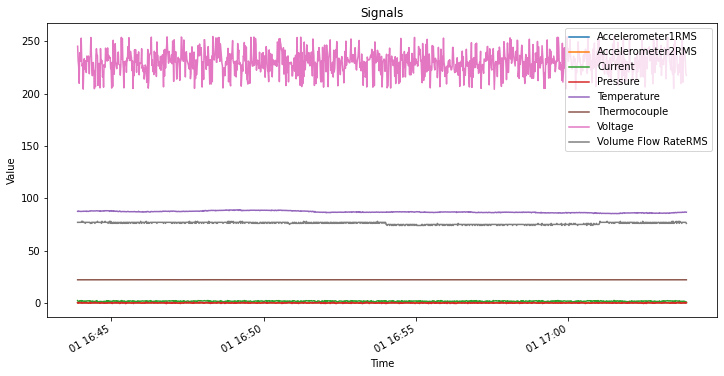

In [11]:
df = pd.read_csv("data/other/3.csv", sep=";", index_col="datetime", parse_dates=True)
anomalies = df["anomaly"]; changepoints = df["changepoint"]
df.drop(["anomaly", "changepoint"], inplace=True, axis=1)
df.sort_index(inplace=True)

df.plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

#### Строим матрицу памяти $D$

1. Добавляем максимальные и минимальные характеристики по каждому измерению. То есть, например, все временные метки в которых максимальная/минимальная температура/давление/ток, и так далее по списку.

In [147]:
train_size = 400

In [148]:
df_train = df[:train_size]
D = pd.DataFrame()

max_values = df_train.loc[df_train.idxmax(axis=0)]
D = pd.concat([D, max_values])

2. Теперь посчитаем норму для каждого вектора и добавим ее во фрейм

In [149]:
df_copy = df_train.copy()
df_copy["Norm"] = np.linalg.norm(df_copy, axis=1)
df_copy.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,Norm
datetime,,,,,,,,,
2020-03-01 16:43:54,0.080156,0.133327,2.189720,0.382638,87.5483,22.0839,245.320,76.9806,272.516576
2020-03-01 16:43:55,0.079986,0.137287,1.678980,-0.273216,87.8090,22.0847,231.669,77.0000,260.385481
2020-03-01 16:43:56,0.081473,0.131053,1.069850,-0.273216,87.4204,22.0849,226.153,77.0000,255.353660
2020-03-01 16:43:57,0.080830,0.131653,0.607355,0.382638,87.6346,22.0831,209.877,77.0000,241.133533
2020-03-01 16:43:58,0.080543,0.132672,2.027280,0.382638,87.5414,22.0831,239.048,77.0000,266.886468


3. Добиваем матрицу $D$ оставшимися значениями через фиксированный интервал. Размер матрицы $D$ задается пользователем.

In [150]:
df_copy.sort_values("Norm", inplace=True)
df_copy.drop(D.index, inplace=True)

sample = df_copy.sample(frac=0.9, random_state=1)
D = pd.concat([D, sample])

Матрица $D$ готова. Все, что не попало в нее, переходит в матрицу $L$.

In [151]:
L = df_copy.drop(sample.index)

In [152]:
D.shape[0] + L.shape[0] == df_train.shape[0]

True

Нормы больше не нужны, убираем.

In [153]:
D.drop(["Norm"], inplace=True, axis=1)
D.sort_index(inplace=True)

L.drop(["Norm"], inplace=True, axis=1)
L.sort_index(inplace=True)

In [154]:
SS = StandardScaler()
D = SS.fit_transform(D).T
L = SS.transform(L).T

#### Теперь будем оценивать данные с аномалиями

In [155]:
df_an = df
df_an.sort_index(inplace=True)

In [156]:
X_obs = SS.transform(np.array(df_an)).T

$X_{est} = D [D^TD]^{-1} [ D^T X_{obs}]$

где $[A B]$ нелинейное произведение вместо обычного умножения матриц. Это связано с тем, что реальные системы редко бывают линейныйми, т.е. когда сигналы коррелируют между собой. Подробнее в документе [Proactive Fault Monitoring in Enterprise Servers, Kenny Gross, Keith Whisnant
](https://www.researchgate.net/profile/Kenny-Gross/publication/220863240_Proactive_Fault_Monitoring_in_Enterprise_Servers/links/00b7d52a8e9a5c4340000000/Proactive-Fault-Monitoring-in-Enterprise-Servers.pdf)

Ниже импортируются функции для нелинейной операции, взятые из [SKAB/MSET](https://github.com/waico/SKAB/blob/master/notebooks/MSET.ipynb)

In [9]:
from models.mset import kernel, otimes

In [158]:
DD = otimes(np.array(D), np.array(D))
DX_obs = otimes(np.array(D), np.array(X_obs))
W = np.linalg.inv(DD) @ DX_obs

X_est = np.array(D) @ W
X_est = SS.inverse_transform(X_est.T).T

### Проверка тождества

Хотим решить задачу представления $X_{obs}$ как линейной комбинации векторов из $D$ c весами $W$.
То есть представить $X_{obs}$ в плоскости, содержащей вектора из $D$. Тогда $X_{obs}$ - $DW$ будет перпендикулярен этой плоскости.

$D^T (X_{obs} - DW) ~= 0$

In [159]:
m = D.T @ (X_obs - D @ W)
s = pd.Series((m.reshape(-1)))

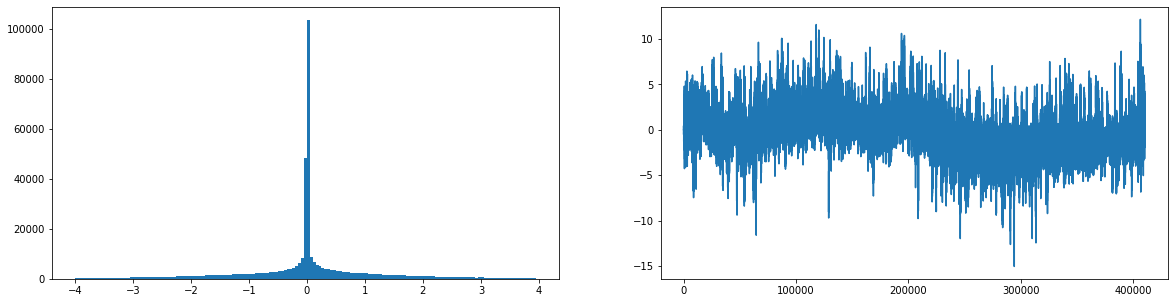

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].hist(s, np.arange(-4,4,0.05))
axes[1].plot(m.reshape(-1))
plt.show()

### Визуализация

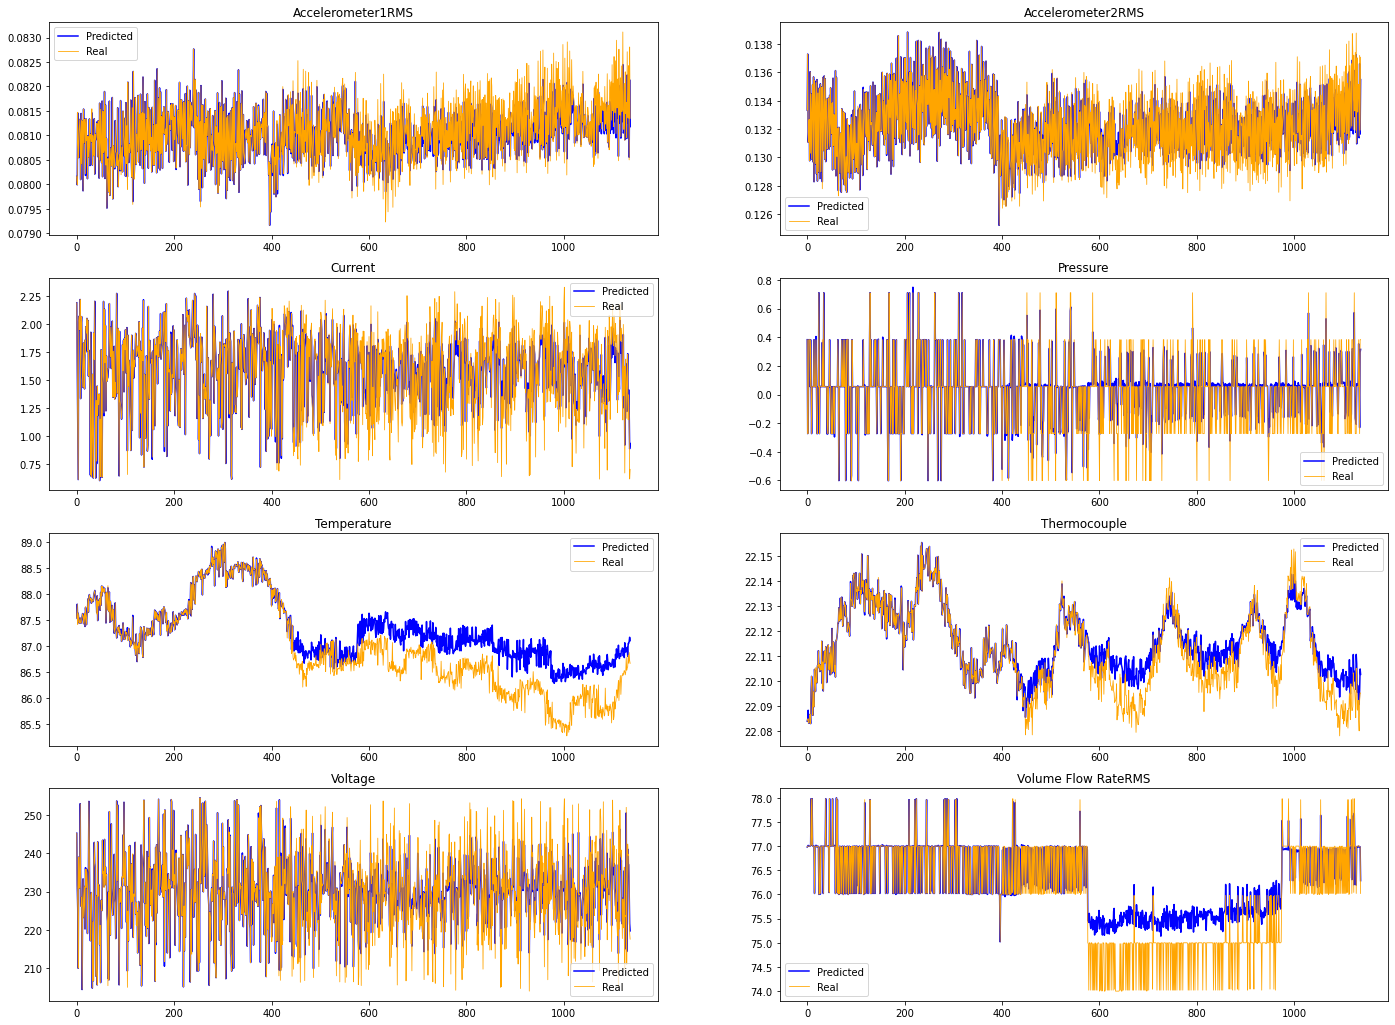

In [161]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(df_an.shape[1]//2, 2, figsize=(24, 18))
for i in range(len(df_an.columns)):
    ax = axes.flatten()[int(i)]
    ax.plot(X_est[i], color='blue', label="Predicted")
    ax.plot(np.array(df_an.T)[i], color='orange', label="Real", linewidth=0.8)
    ax.set_title(f"{df.columns[i]}")
    ax.legend()

plt.show()

Графики остатков по каждой из характеристик выглядят так

In [162]:
rest = np.array(df_an.T) - X_est

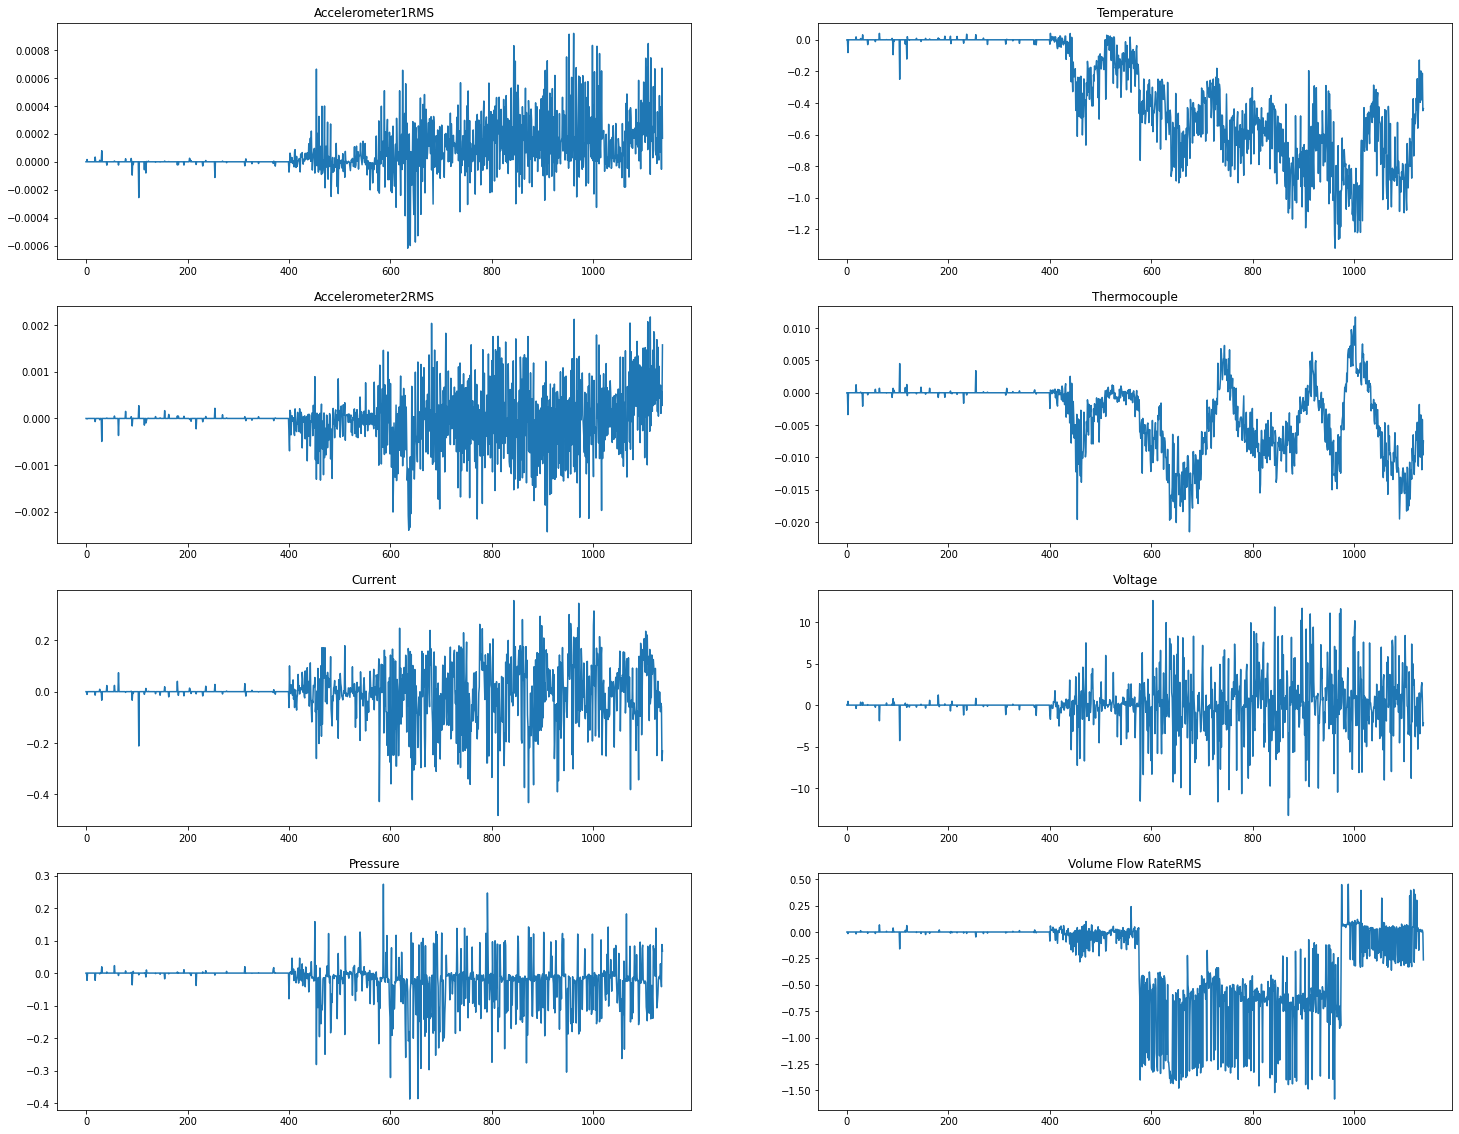

In [163]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(25, 20))

for i in range(rest.shape[0]):
    j = 1 if i >= 4 else 0
    axes[i%4, j].plot(rest[i])
    axes[i%4, j].set_title(df.columns[i])
plt.show()

In [1]:
def movmean(array, window):

    n = np.size(array)
    xx = array.copy()
    y = []
    for i in range(0, window):
        y.append(np.roll(xx.tolist() + [np.nan]*window, i))
    y = np.nanmean(y, axis=0)
    l = math.ceil(window/2)

    return y[l-1:n+l-1]

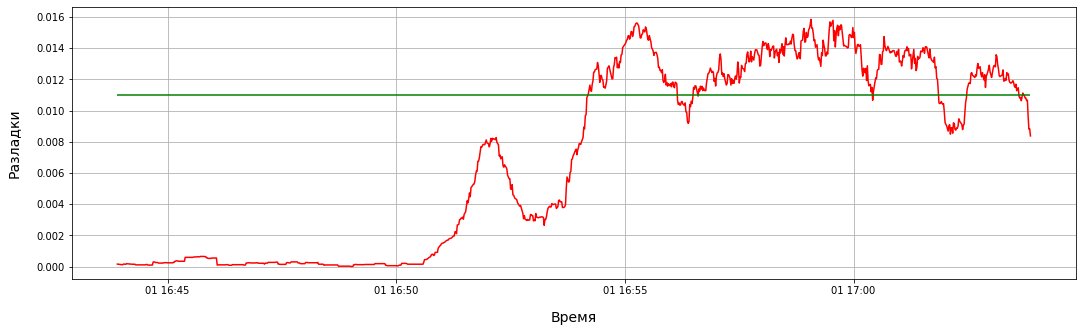

In [165]:
err = np.linalg.norm((X_est.T - df_an), axis=1)
rel_err = movmean(err/np.linalg.norm(X_est.T, axis=1), window=40)

UCL = 0.011
plt.figure(figsize=(18,5))

plt.plot(df_an.index, rel_err, c='r')
plt.hlines(UCL, df_an.index[0], df_an.index[-1], 'g')

plt.grid()
plt.xlabel('Время', labelpad=15, fontsize=14)
plt.ylabel('Разладки', labelpad=15, fontsize=14);

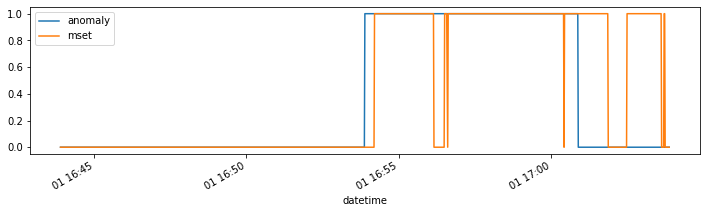

In [166]:
prediction = pd.DataFrame((rel_err > UCL), df_an.index).fillna(0).any(axis=1).astype(int)
anomalies.plot(figsize=(12,3))
plt.plot(df_an.index, prediction, label = 'mset')
plt.legend()
plt.show()

### Оценка качества модели

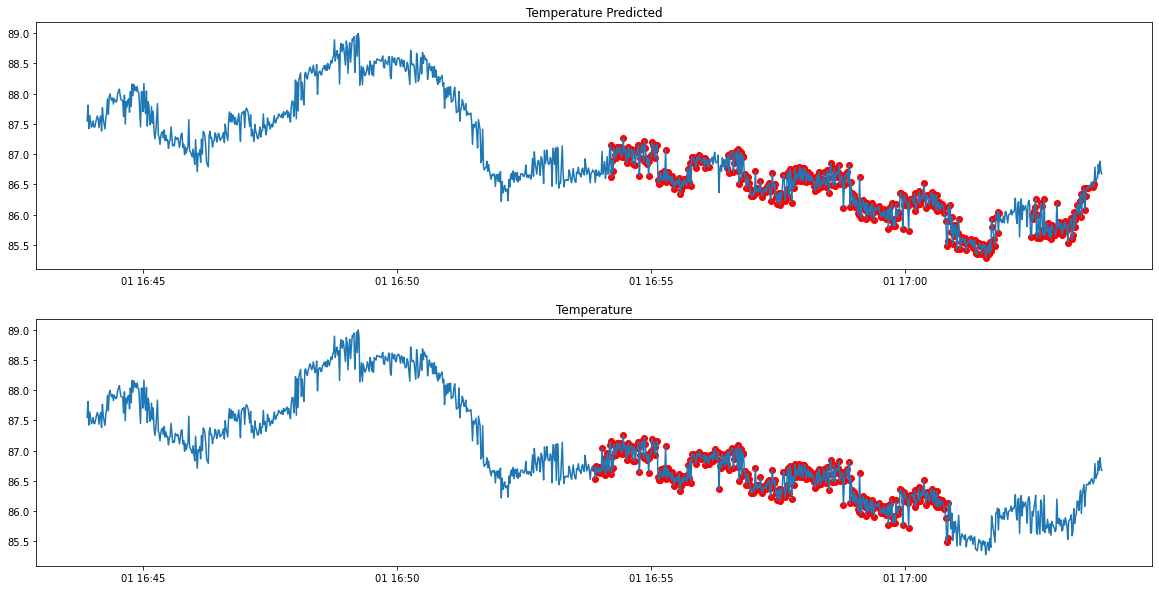

In [167]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df_an.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(df_an.T[anomalies_indecies].T.index, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(anomalies)
anomalies_indecies = y.index[y == 1]
axs[1].scatter(df_an.T[anomalies_indecies].T.index, temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

$$\large MAR = \frac{FN}{TP + FN}$$

$$\large FAR = \frac{FP}{FP + TN}$$

In [168]:
print(f"""F1 = {f1_score(anomalies, prediction)}
FAR = {far(anomalies, prediction)}
MAR = {mar(anomalies, prediction)}""")

F1 = 0.8154897494305239
FAR = 0.16508795669824086
MAR = 0.10050251256281408


### Применение метода ко всем датасетам

Для используемых данных есть три вида аномалий: valve1 - закрытый клапан на выходе, valve2 - закрытый клапан на входе, other - другие аномалии. Поскольку природа аномалий в этих группах разная, то логичнее будет применить метод отдельно к каждой группе.

In [2]:
from utils.pipeline import Pipeline, Predictor
from models.mset import MSET

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import warnings 
warnings.filterwarnings('ignore')

In [3]:
class Config:
    train_size = 400
    window_size = 40
    Q = 0.6 # We know that 35% it is anomalies

In [4]:
class MsetPredictor(Predictor):
    def make_prediction(self, df):

        df = df.drop(['anomaly','changepoint'], axis=1)

        mset = MSET()
        mset.fit(df[:Config.train_size])

        y_pred = mset.predict(df)

        err = np.linalg.norm((y_pred.T - df), axis=1)
        rel_err = movmean(err/np.linalg.norm(y_pred.T, axis=1), window=Config.window_size)
        UCL = pd.Series(rel_err).quantile(Config.Q)

        prediction = pd.DataFrame((rel_err > UCL), df.index).fillna(0).any(axis=1).astype(int)
        return prediction

Anomaly: valve1


IntProgress(value=0, description='Computing', max=16, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.719316340061883

FAR = 0.2010800776305797

MAR = 0.22618481534316057

Anomaly: valve2


IntProgress(value=0, description='Computing', max=4, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.7624922887106724

FAR = 0.1749552772808587

MAR = 0.1852340145023072

Anomaly: other0


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.7529665587918015

FAR = 0.17185385656292287

MAR = 0.2261640798226164

Anomaly: other1


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.9336437718277066

FAR = 0.07671601615074024

MAR = 0.0

Anomaly: other2


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.7935779816513762

FAR = 0.15570469798657718

MAR = 0.15609756097560976

Anomaly: other3


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.6978021978021978

FAR = 0.2232746955345061

MAR = 0.1779935275080906

Anomaly: other4


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.5488958990536278

FAR = 0.29635258358662614

MAR = 0.3433962264150943

Anomaly: other5


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.7971864009378663

FAR = 0.15561569688768606

MAR = 0.1457286432160804

Anomaly: other6


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.7736625514403292

FAR = 0.19748653500897667

MAR = 0.0

Anomaly: other7


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.8863346104725415

FAR = 0.11978465679676985

MAR = 0.0

Anomaly: other8


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.7681289167412713

FAR = 0.13765182186234817

MAR = 0.26791808873720135

Anomaly: other9


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.9096385542168675

FAR = 0.09950248756218906

MAR = 0.0

Anomaly: other10


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.44087256027554533

FAR = 0.35678391959798994

MAR = 0.5139240506329114

Anomaly: other11


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.9337979094076655

FAR = 0.07651006711409396

MAR = 0.0

Anomaly: other12


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.665893271461717

FAR = 0.23118279569892472

MAR = 0.2878411910669975

Anomaly: other13


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.6206896551724138

FAR = 0.24242424242424243

MAR = 0.4375

Anomaly: all


IntProgress(value=0, description='Computing', max=34, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.7381640443826037

FAR = 0.18973452782115557

MAR = 0.20831101247417158



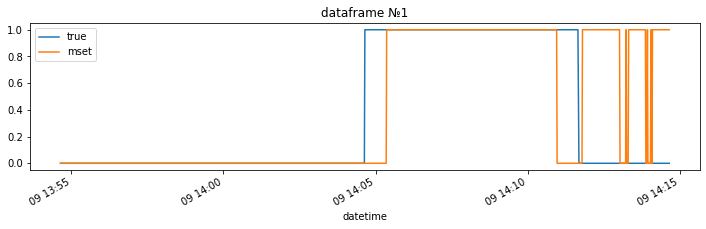

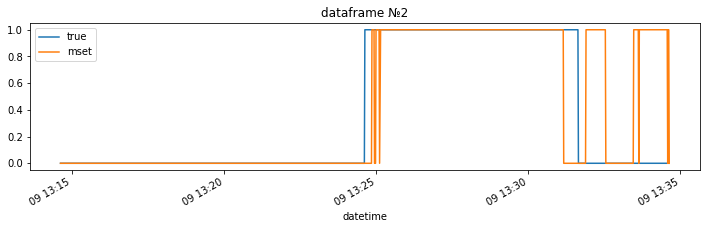

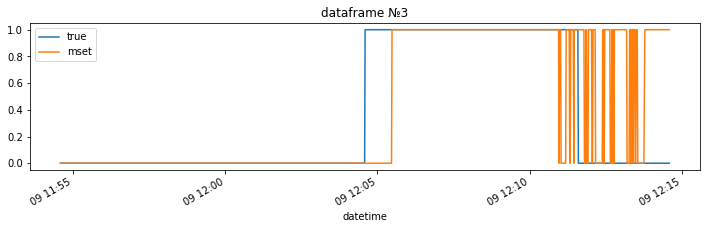

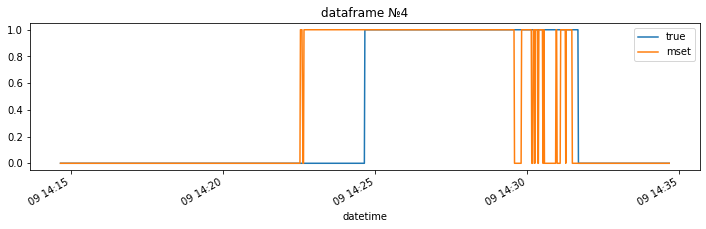

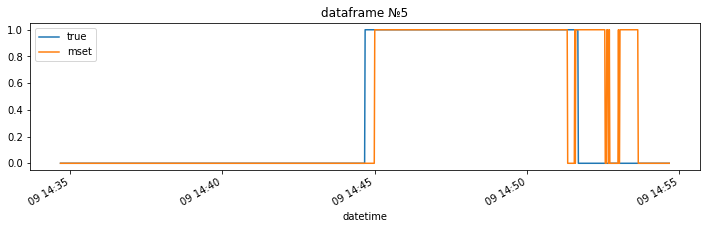

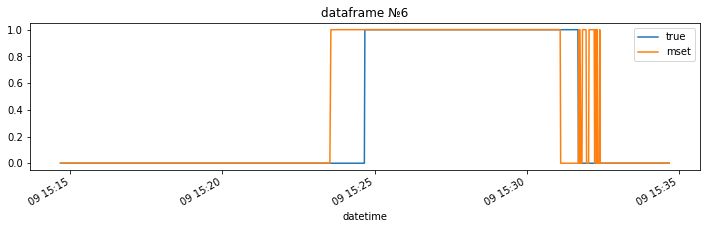

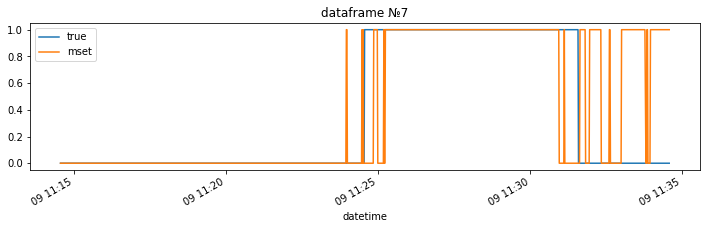

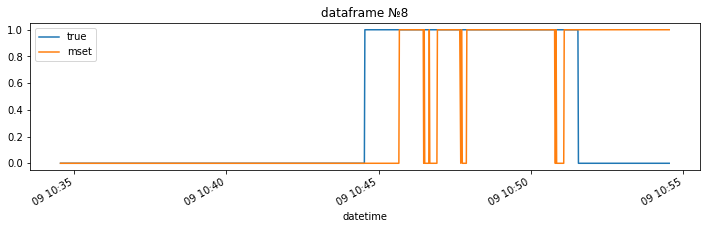

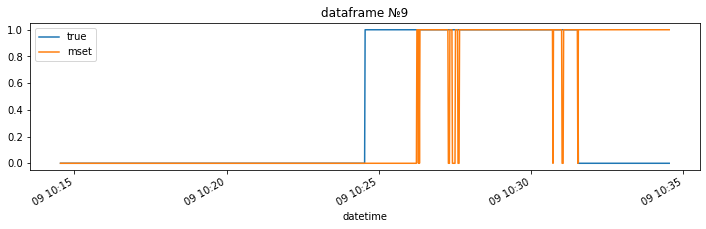

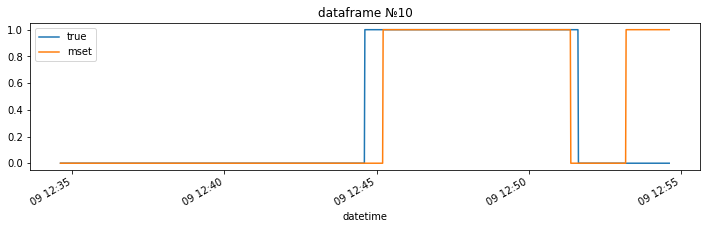

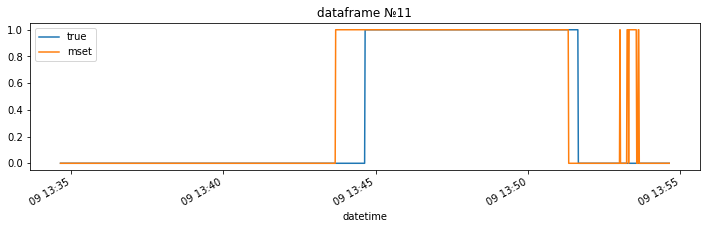

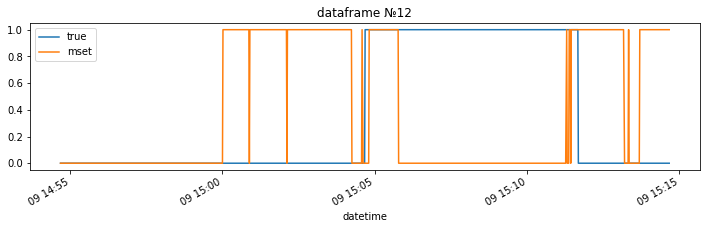

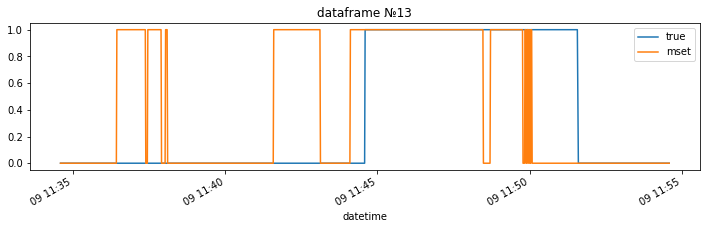

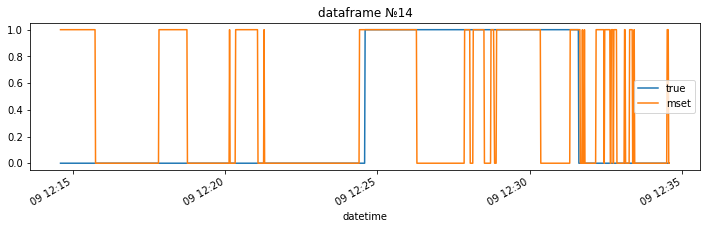

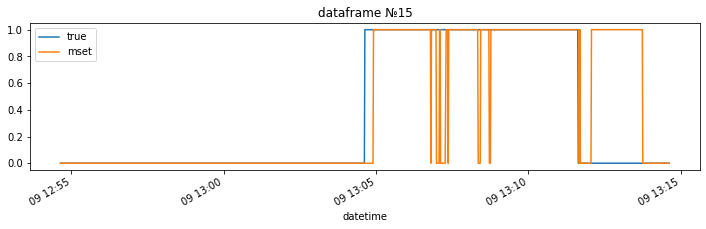

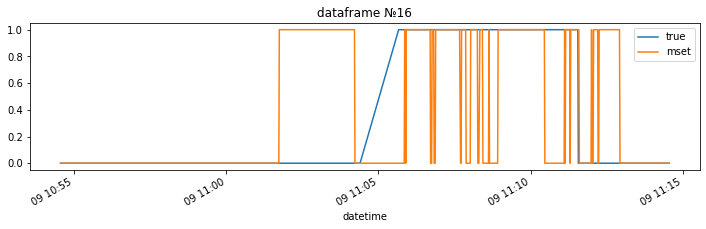

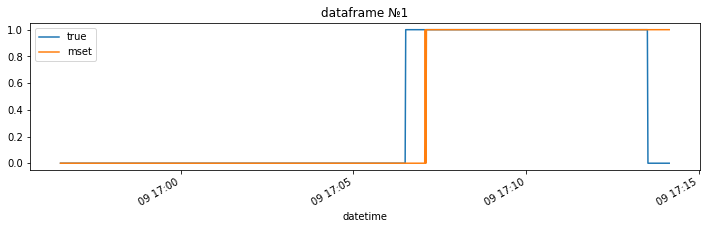

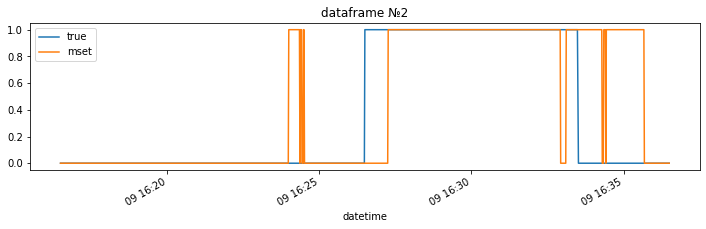

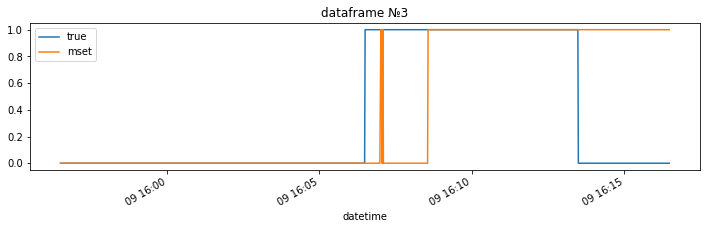

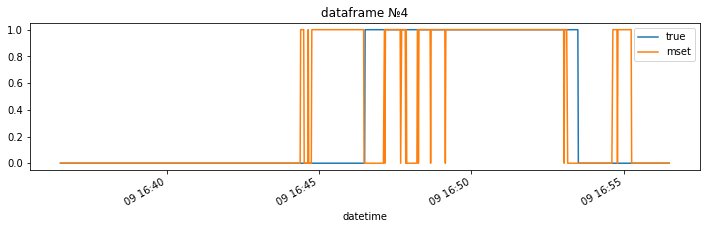

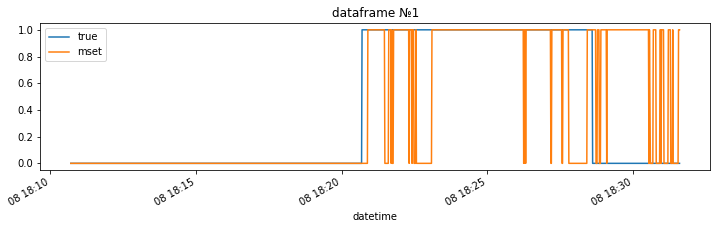

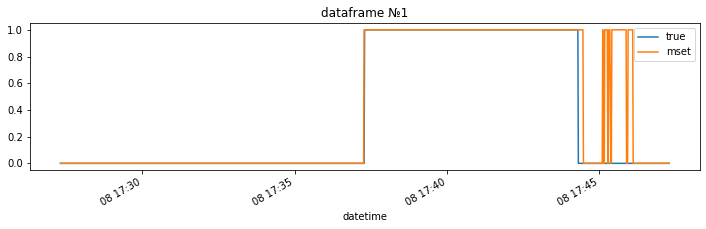

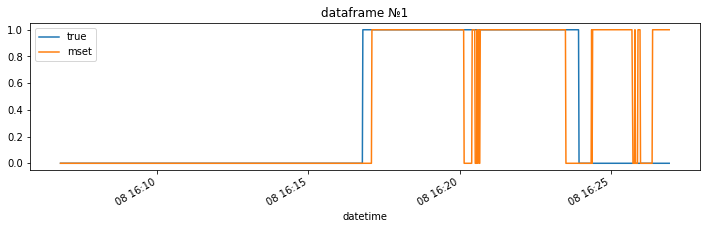

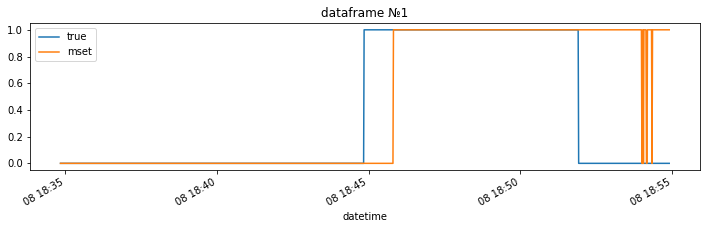

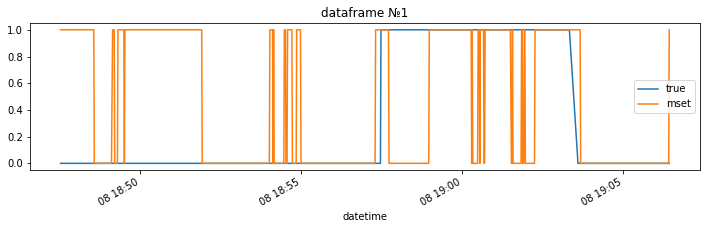

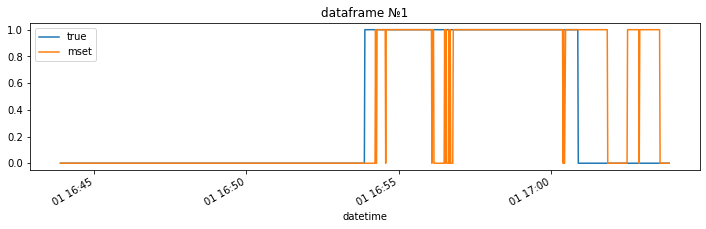

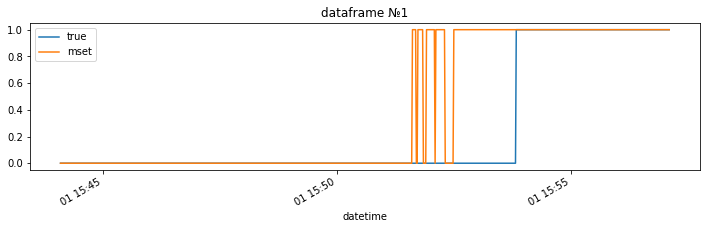

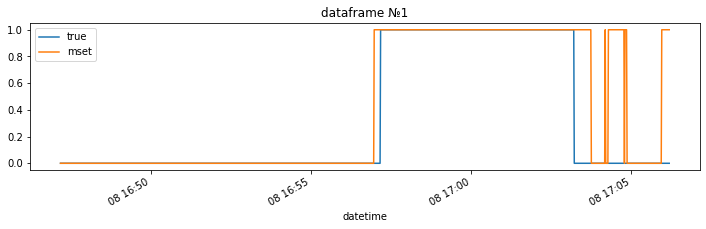

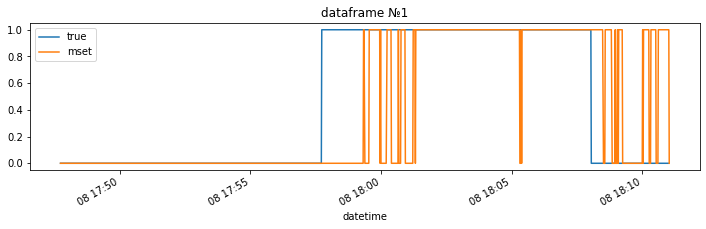

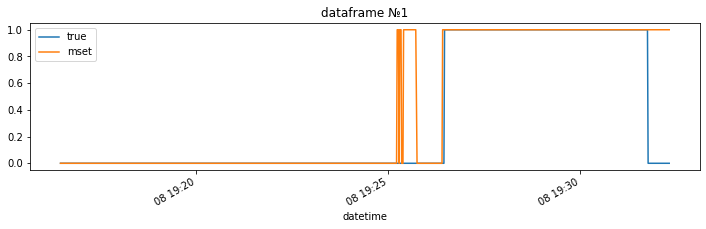

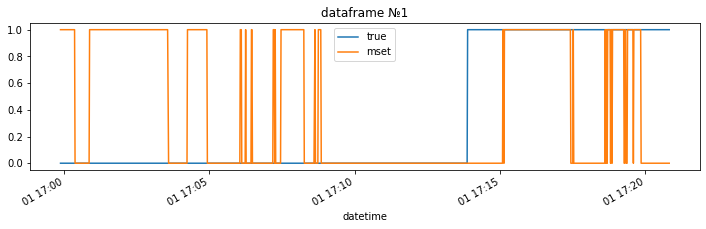

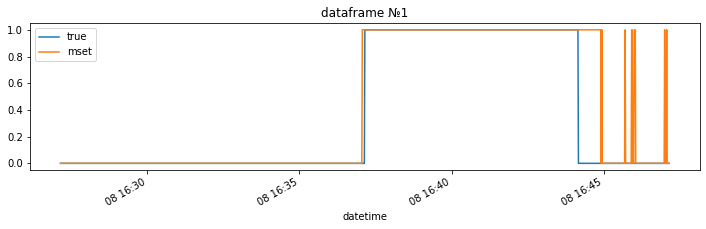

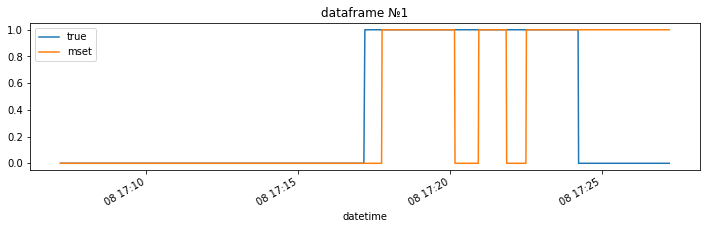

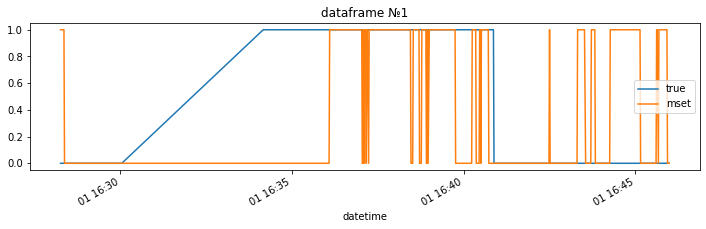

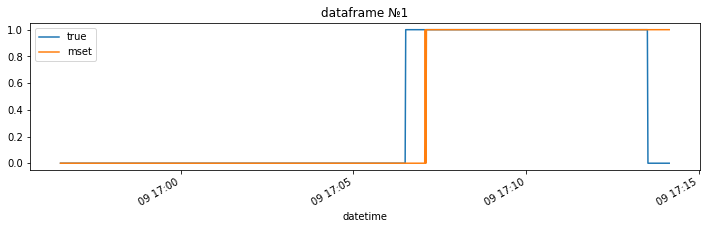

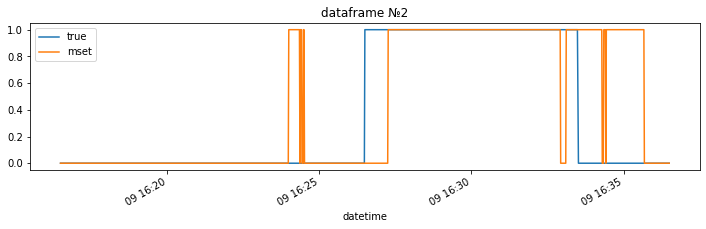

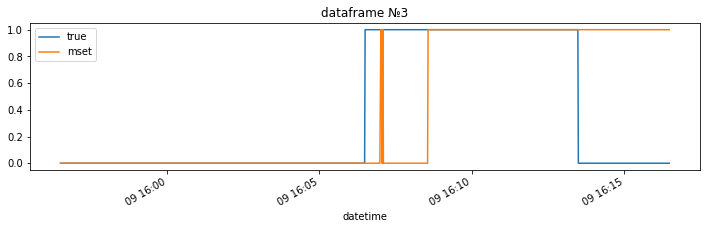

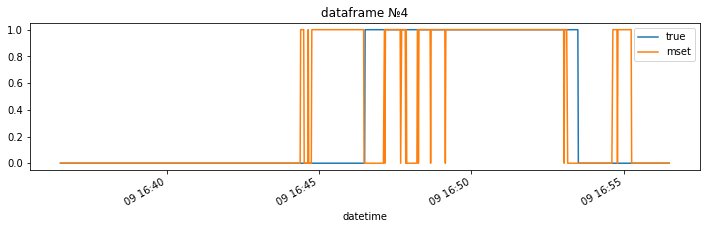

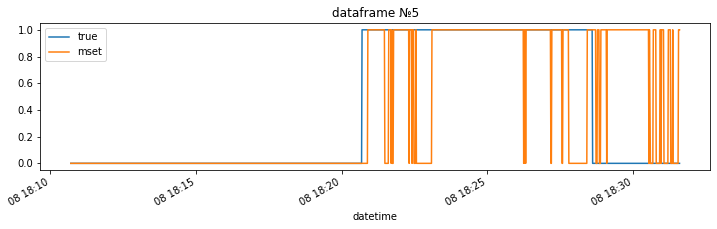

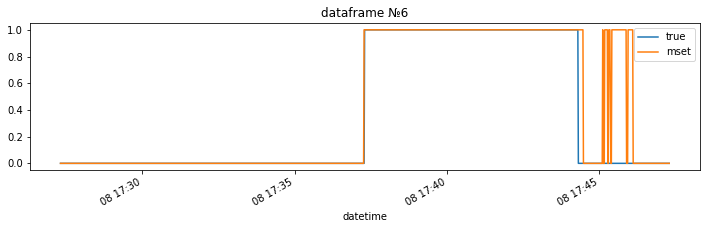

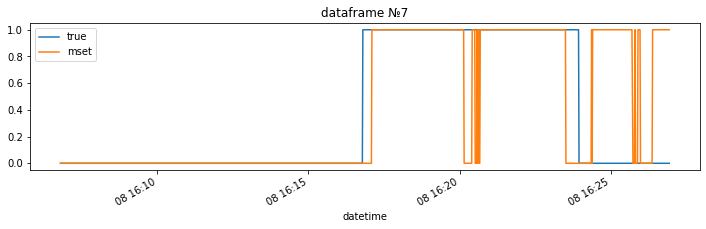

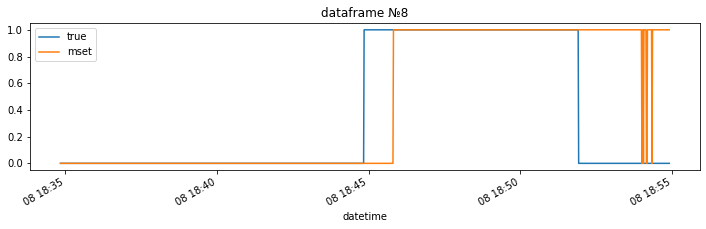

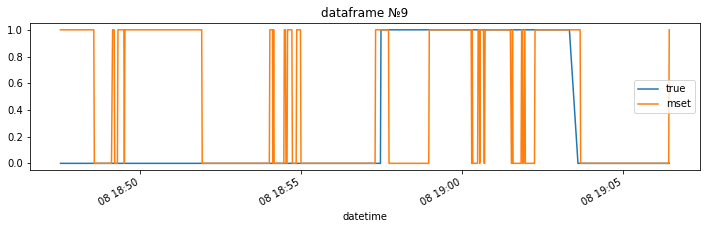

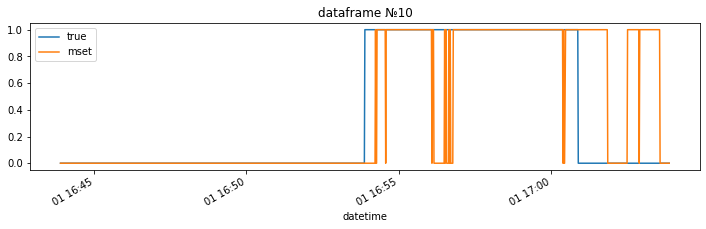

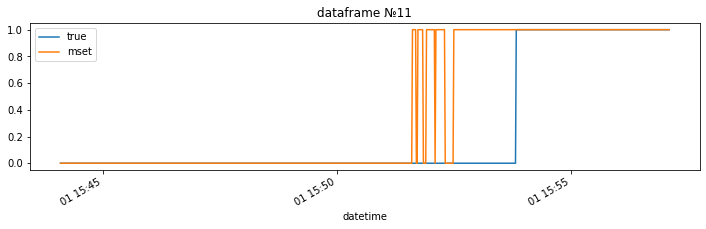

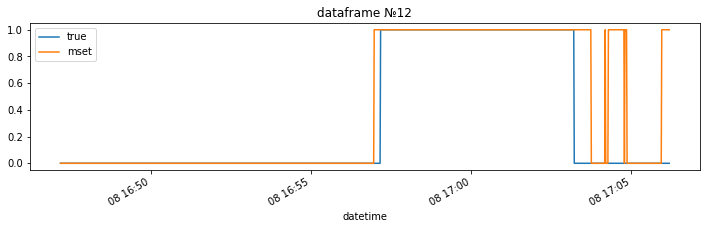

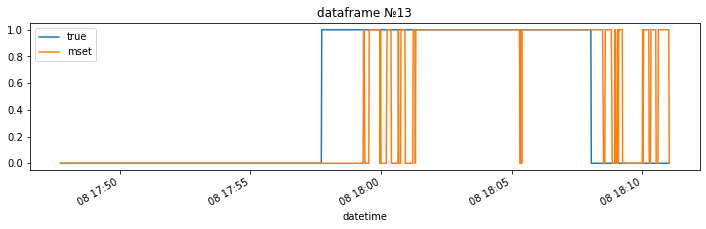

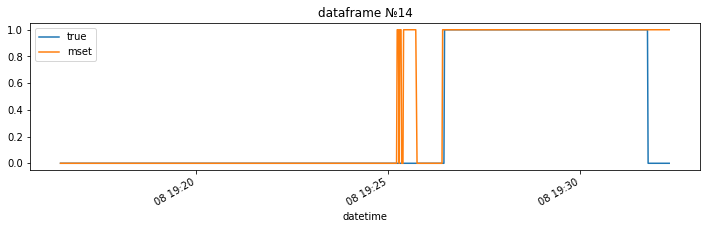

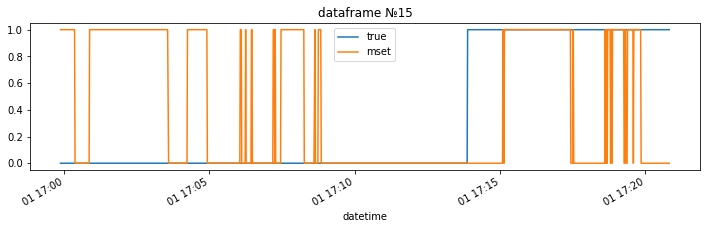

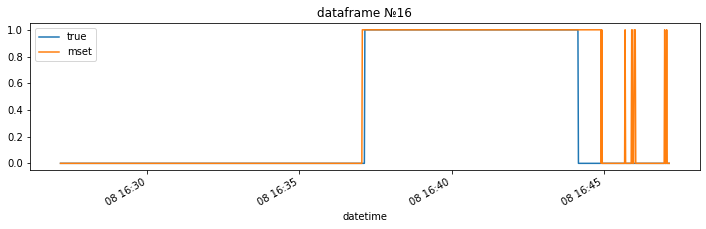

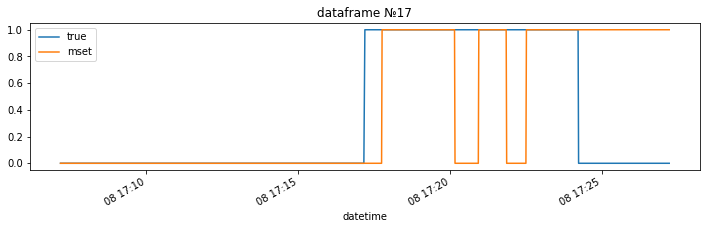

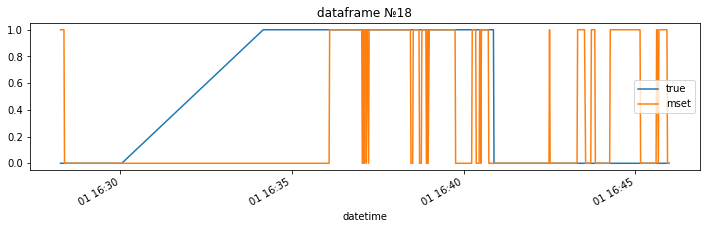

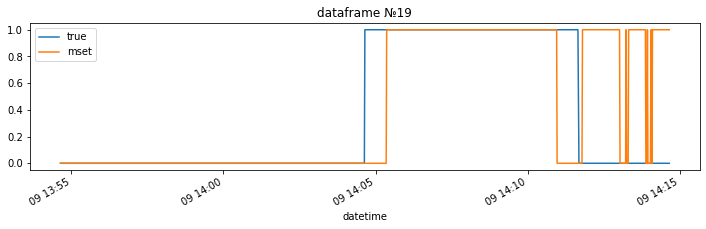

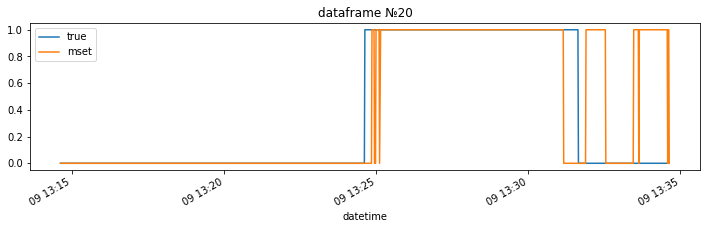

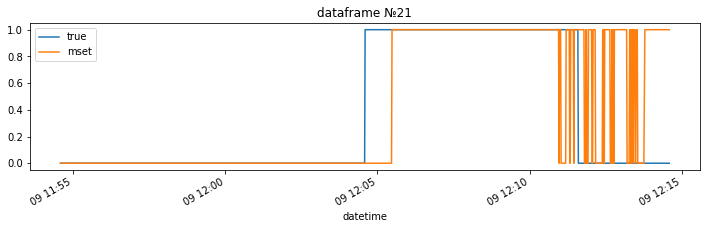

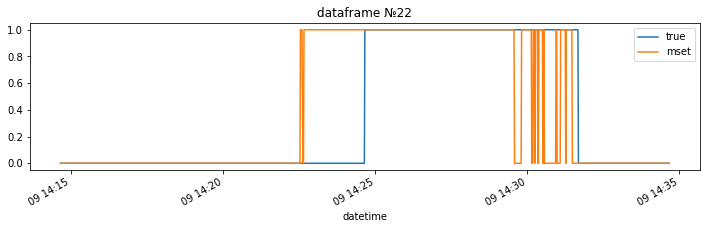

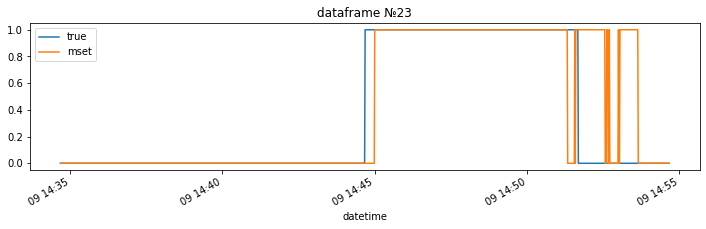

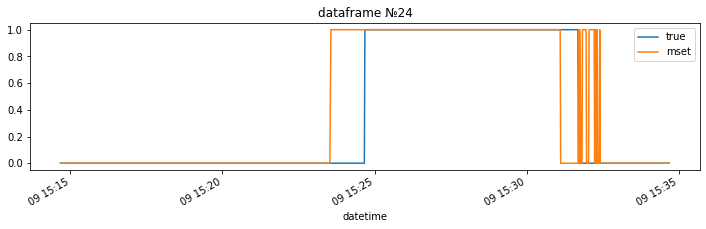

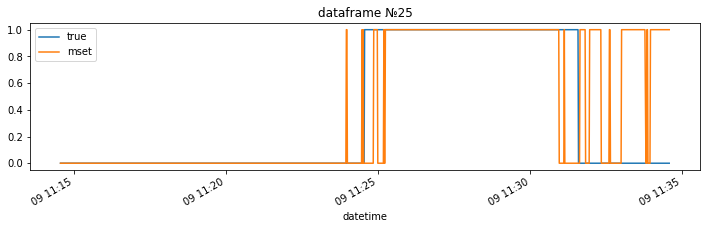

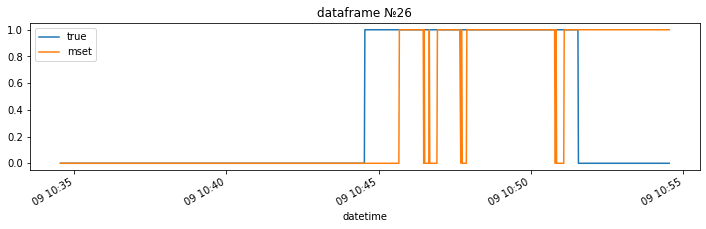

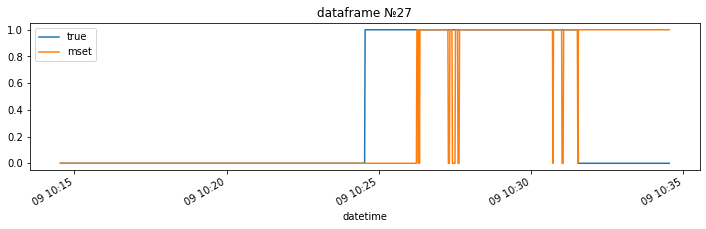

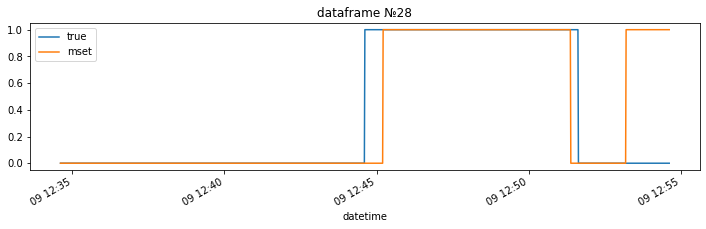

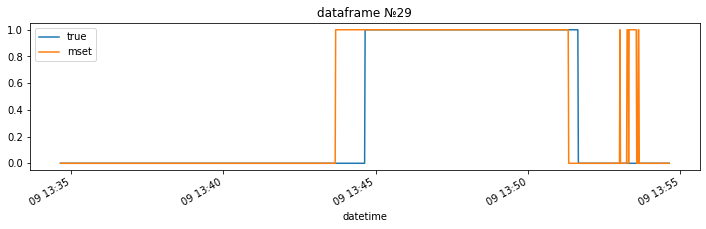

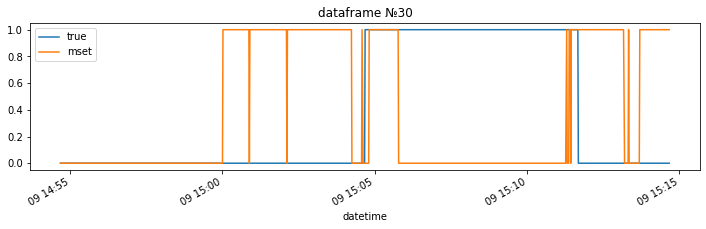

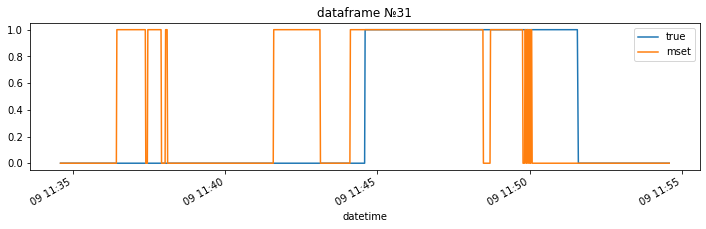

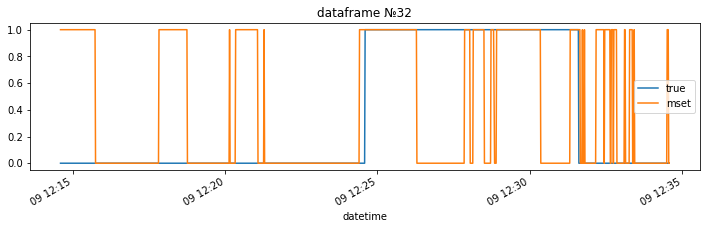

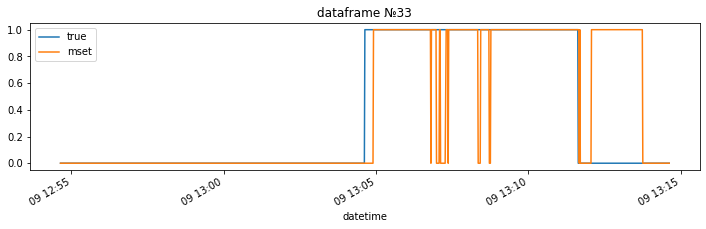

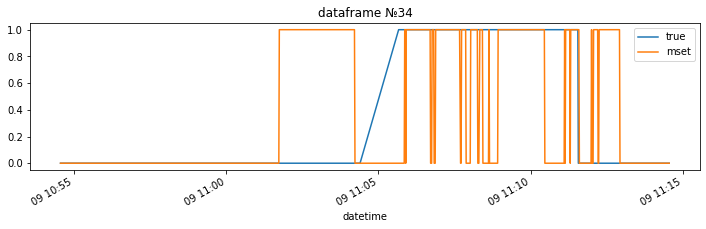

In [5]:
from utils.data import load_df

anomaly_types = ("valve1", "valve2", "other", "all", )
anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

predictor = MsetPredictor()
p = Pipeline()

metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [6]:
from utils.data import show_score_table

In [7]:
show_score_table(metrics)

metric | valve1 | valve2 | other0 | other1 | other2 | other3 | other4 | other5 | other6 | other7 | other8 | other9 | other10 | other11 | other12 | other13 | all
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.72 | 0.76 | 0.75 | 0.93 | 0.79 | 0.7 | 0.55 | 0.8 | 0.77 | 0.89 | 0.77 | 0.91 | 0.44 | 0.93 | 0.67 | 0.62 | 0.74
FAR |0.2 | 0.17 | 0.17 | 0.08 | 0.16 | 0.22 | 0.3 | 0.16 | 0.2 | 0.12 | 0.14 | 0.1 | 0.36 | 0.08 | 0.23 | 0.24 | 0.19
MAR |0.23 | 0.19 | 0.23 | 0.0 | 0.16 | 0.18 | 0.34 | 0.15 | 0.0 | 0.0 | 0.27 | 0.0 | 0.51 | 0.0 | 0.29 | 0.44 | 0.21